# Cross-matching the TESS Input Catalog

The TESS Input Catalog (TIC) is a great resource for selecting TESS targets, but it doesn't have everything! It's useful to cross-match sources in the TIC with other catalogs. In this demo, we'll do basic crossmatches with the Pan-STARRS 1 (PS1) catalog using the `astroML` package, and with Gaia DR3 using `astroquery`.

We will follow these steps:
1. Query MAST catalogs
2. Cross-match with Pan-STARRS 1
3. Cross-match with Gaia DR3

Here are the packages we'll need:
- numpy # for computational purposes
- matplotlib # for plotting
- astroquery.mast # to query the catalogs
- astroML # for cross-matching routines

First install `astroML`

In [1]:
%conda install -c astropy astroML

Retrieving notices: done
Channels:
 - astropy
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.0
    latest version: 24.11.3

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda/envs/tess

  added / updated specs:
    - astroml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    astroml-1.0.2.post1        |     pyhd8ed1ab_0          92 KB  astropy
    astropy-6.1.4              |  py311h9f3472d_0         9.1 MB  astropy
    astropy-iers-data-0.2025.1.6.0.33.42|     pyhd8ed1ab_0         1.2 MB  conda-forge
    brotli-1.1.0               |       hb9d3cd8_2          19 KB  conda-forge
    brotli-bin-1.1.0           |       hb9d3cd8_2          18 KB  conda-forge
    ca-certificates-2024.12.14 |       hbcca054_0         1

In [2]:
# Then import needed packages:
import numpy as np
import astroML
from astroquery.mast import Catalogs
import matplotlib.pyplot as plt

## Step 1. Query MAST catalogs

First, do a conesearch of the TIC and Pan-STARRS in the same region of the sky.

In [3]:
tic_data = Catalogs.query_region("290.447 44.5",radius = 0.2,catalog='TIC')

ps1_data = Catalogs.query_region("290.447 44.5",radius = 0.2,catalog='PANSTARRS',table='mean',data_release='dr2')

Now let's plot the stars within that region, for both the TIC and PS1.

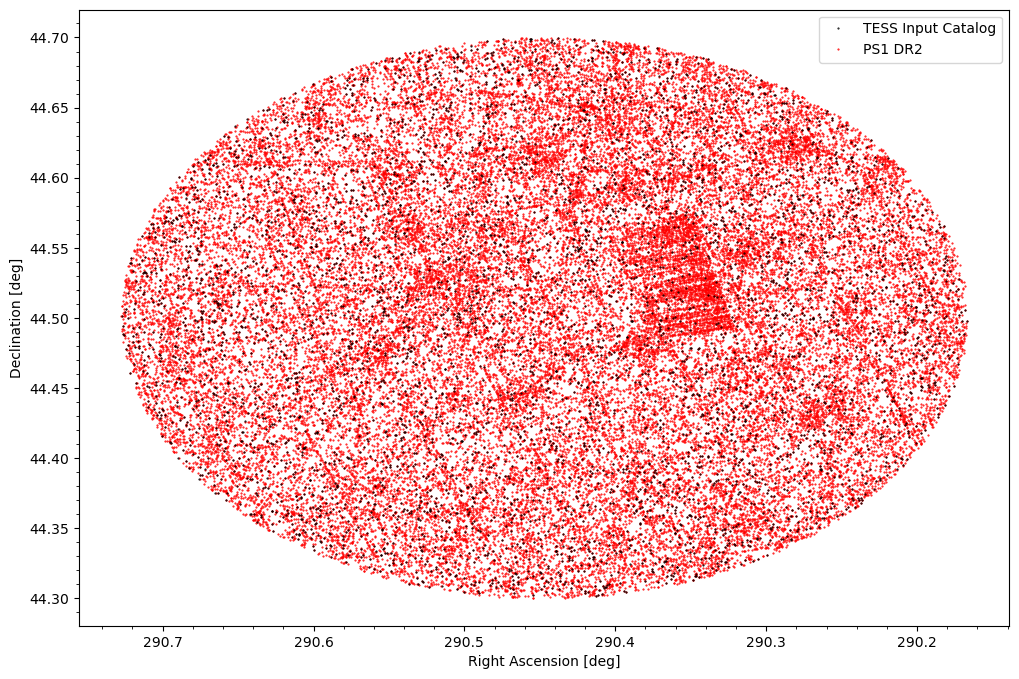

In [4]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.plot(tic_data['ra'],tic_data['dec'],'k.',ms=1,label='TESS Input Catalog')
plt.plot(ps1_data['raMean'],ps1_data['decMean'],'r.',ms=1,label='PS1 DR2',zorder=1)
plt.legend(loc='best')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.minorticks_on()
plt.gca().invert_xaxis()
plt.show()

Notice how there are many more PS1 sources (red) than TIC sources (black). This is because the PS1 catalog goes deeper than the TIC, so it includes dimmer objects.

## Step 2: Cross-match with PS1

Now that we have sources from both catalogs, we can do a simple crossmatch with their current positions.

In [5]:
from astroML.crossmatch import crossmatch_angular
dist, ind = crossmatch_angular(np.transpose([tic_data['ra'],tic_data['dec']]),np.transpose([ps1_data['raMean'],ps1_data['decMean']]),3./3600.)

Define mask to ignore objects without matches and ones that go over the maximum array length (inf designation according to astroML package documentation). Then, plot the histogram of separations.


In [6]:
mask_cross = np.where((dist < 1.) & (ind < 51032))[0]

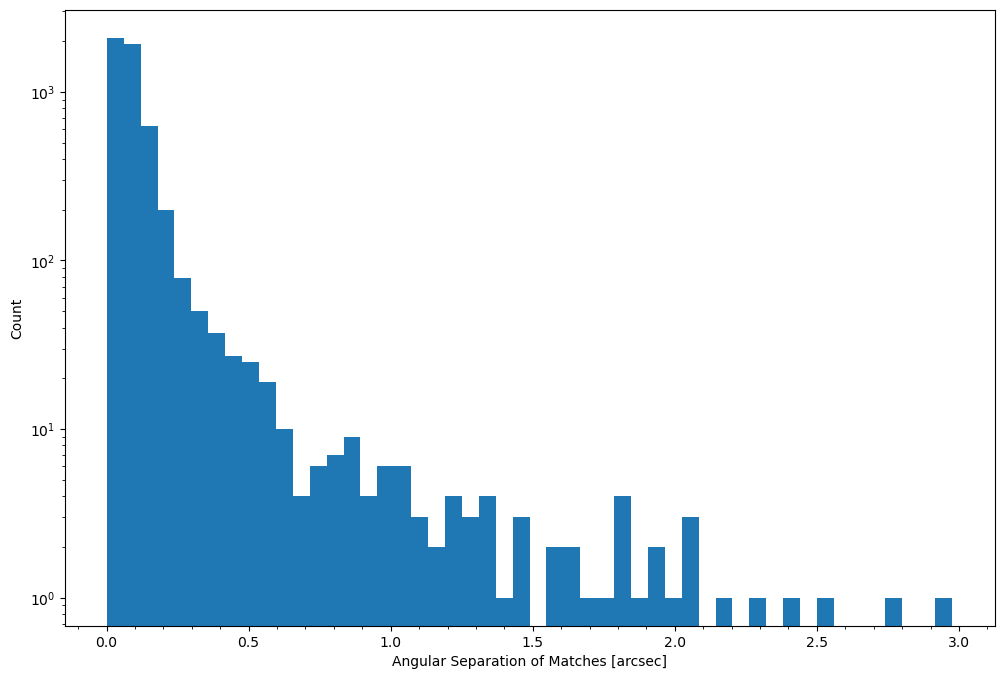

In [7]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.hist(dist[mask_cross]*3600.,bins=50)
plt.xlabel('Angular Separation of Matches [arcsec]')
plt.ylabel('Count')
plt.yscale('log')
plt.minorticks_on()
plt.show()

Now let's zoom in on a particular region of the sky and see what's going on:

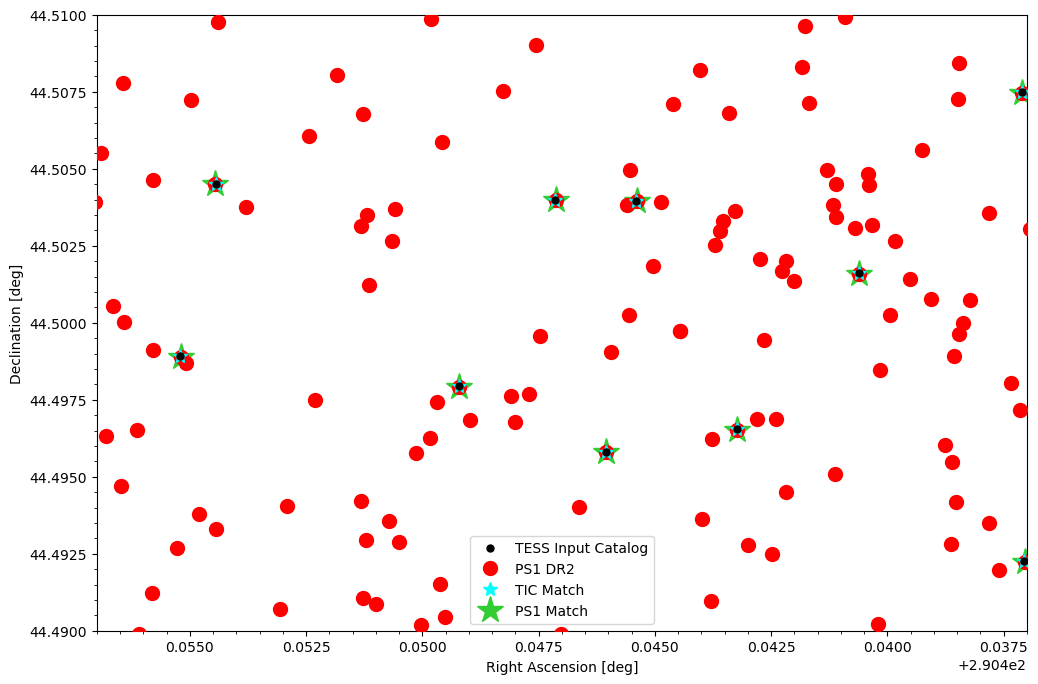

In [8]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.plot(tic_data['ra'],tic_data['dec'],'k.',ms=10,label='TESS Input Catalog',zorder=5)
plt.plot(ps1_data['raMean'],ps1_data['decMean'],'r.',ms=20,label='PS1 DR2',zorder=3)
plt.plot(tic_data[mask_cross]['ra'],tic_data[mask_cross]['dec'],c='cyan',marker='*',ms=10,linestyle='',label='TIC Match',zorder=4)
plt.plot(ps1_data[ind[mask_cross]]['raMean'],ps1_data[ind[mask_cross]]['decMean'],c='limegreen',marker='*',ms=20,linestyle='',label='PS1 Match',zorder=1)
plt.legend(loc='best')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.xlim([290.437,290.457])
plt.ylim([44.49,44.51])
plt.minorticks_on()
plt.gca().invert_xaxis()
plt.show()

We can also compare magnitudes between stars in the TIC and those in PS1. Let's choose filters with similar wavelengths (TESSmag and imag):

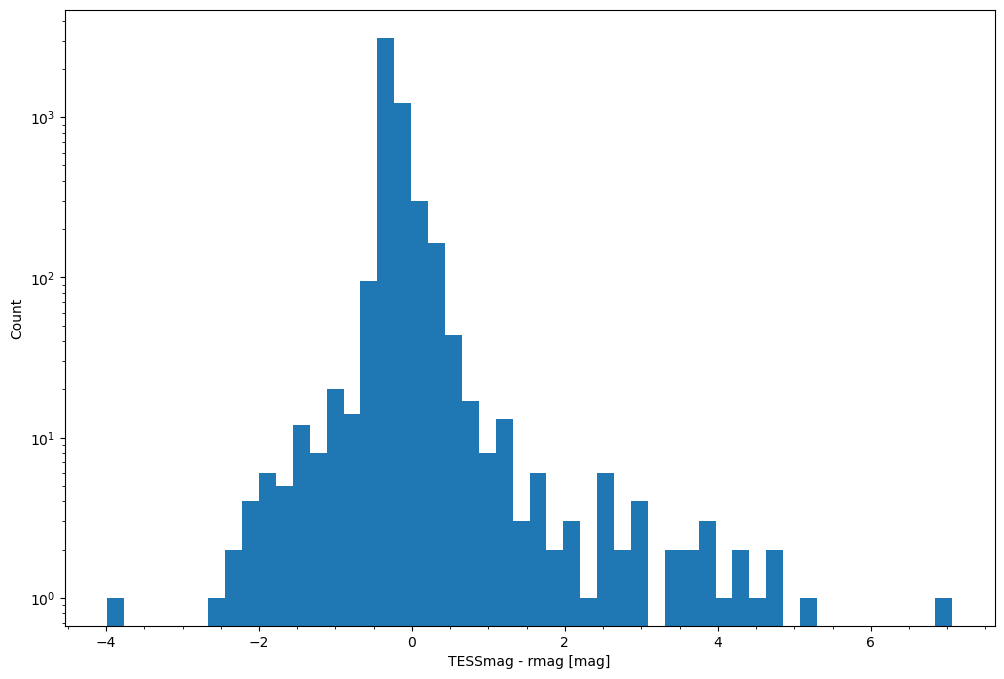

In [9]:
# Plot the comparison:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.hist(tic_data[mask_cross]['Tmag'] - ps1_data[ind[mask_cross]]['iMeanPSFMag'],bins=50)
plt.xlabel('TESSmag - rmag [mag]')
plt.ylabel('Count')
plt.yscale('log')
plt.minorticks_on()
plt.show()

You'll notice we get a nice gaussian distribution about roughly 0, but there is some scatter in the magnitudes, with a tail at TESSmag - rmag > 2.0. These are likely giant stars, where color relations are different for stars in different luminosity classes.
The large outliers (~-4 and >6) could be instances where there are issues with the photometry in one or both catalogs or the indication of a false match.

Now this is a bit of an oversimplification - namely, because stars are not stationary and are constantly moving relative to our perspective. A proper crossmatch would include not only positions, but proper motion considerations and time of observation.
Fortunately, the TIC positions and PS1 positions were taken at a similar epoch, but in instances where years separate observations and stars have significant proper motions, a simple crossmatch like this would not be sufficient.
You can already see how small movements of individual stars could result in completely different matches being chosen in a few cases, and this becomes an issue in particularly dense regions of the sky (think galactic plane/nucleus).

## Step 3: Cross-match with Gaia

The `astroquery` package also has some cross-matching tools. Let's use them to cross-match the TIC with Gaia.

In [10]:
from astroquery.xmatch import XMatch # To crossmatch with Gaia DR3 data
from astropy import units as u # Define u for units

# Next, do a conesearch of the TIC to set up eventual crossmatching and plot the distribution of the stars:
tic_data = Catalogs.query_region("290.447 44.5",radius = 0.2,catalog='TIC')

matched_table = XMatch.query(cat1=tic_data,
                     cat2='vizier:I/355/gaiadr3',
                     max_distance=3 * u.arcsec, colRA1='ra',
                     colDec1='dec')

Let's take a look at the resulting cross-matched table:

In [11]:
matched_table

angDist,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec,DR3Name,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,SolID,Source,RandomI,e_RAdeg,e_DEdeg,Plx,e_Plx,RPlx,PM,pmRA2,e_pmRA2,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NbAL,gofAL,chi2AL,epsi,sepsi,Solved,APF,nueff,pscol,e_pscol,RApscolCorr,DEpscolCorr,PlxpscolCorr,pmRApscolCorr,pmDEpscolCorr,MatchObsA,Nper,amax,MatchObs,IPDgofha,IPDgofhp,IPDfmp,IPDfow,RUWE,Dup,o_Gmag,FG,e_FG,RFG,Gmag,e_Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,e_BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,e_RPmag,E(BP/RP),NBPcont,NBPblend,NRPcont,NRPblend,Mode,BP-RP,BP-G,G-RP,RV,e_RV,n_RV,o_RV,o_RVd,RVNper,RVS/N,RVgof,RVchi2,RVTdur,RVamp,RVtempTeff,RVtemplogg,RVtemp[Fe/H],Vatmparam,vbroad,e_Vbroad,o_Vbroad,GRVSmag,e_GRVSmag,o_GRVSmag,RVSS/N,VarFlag,PQSO,PGal,PSS,Teff2,b_Teff,B_Teff,logg2,b_logg,B_logg,[Fe/H],b_[Fe/H],B_[Fe/H],Dist,b_Dist,B_Dist,A0,b_A0,B_A0,AG,b_AG,B_AG,E(BP-RP),b_E(BP-RP),B_E(BP-RP),Lib,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,RADEcorJ2000
arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,,,,mas,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,deg,,,,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,dex(cm / s2),dex,,km / s,km / s,,mag,mag,,,,,,,K,K,K,dex(cm / s2),dex(cm / s2),dex(cm / s2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,deg,deg,,,
float64,int64,float64,float64,float64,float64,float32,str8,str7,int32,bool,str12,str10,str16,bool,str19,int64,int32,int32,str8,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,str5,str5,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float32,float32,float64,float64,int16,float64,str9,int64,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,str6,float32,float32,str5,float32,float64,float32,float64,int16,bool,str8,str8,str13,float64,float64,float64,float64,float64,float64,int16,int16,float64,str28,float64,float64,float32,float32,float32,int64,int64,int32,float32,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,uint8,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,uint8,float32,int16,float32,float32,uint8,uint8,float32,uint8,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,int16,int16,int16,int16,u

Let's plot the stars within that region:

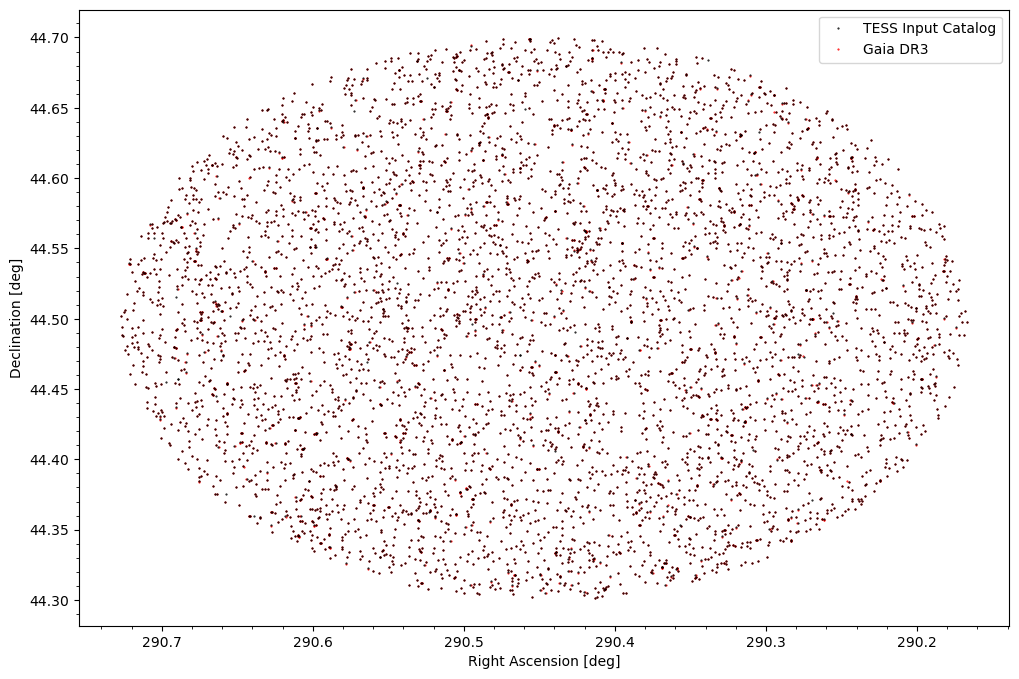

In [12]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.plot(tic_data['ra'],tic_data['dec'],'k.',ms=1,label='TESS Input Catalog')
plt.plot(matched_table['RAdeg'],matched_table['DEdeg'],'r.',ms=1,label='Gaia DR3',zorder=1)
plt.legend(loc='best')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.minorticks_on()
plt.gca().invert_xaxis()
plt.show()

Again, let's plot the histogram of separations.

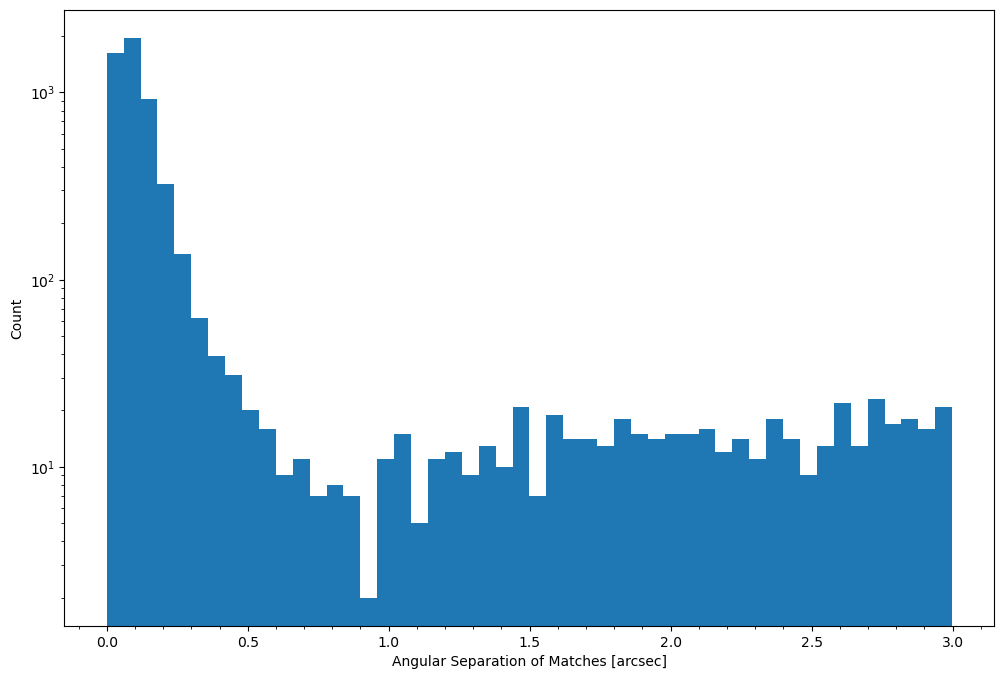

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.hist(matched_table['angDist'],bins=50)
plt.xlabel('Angular Separation of Matches [arcsec]')
plt.ylabel('Count')
plt.yscale('log')
plt.minorticks_on()
plt.show()

Let's zoom in on a particular region of the sky and see what's going on:

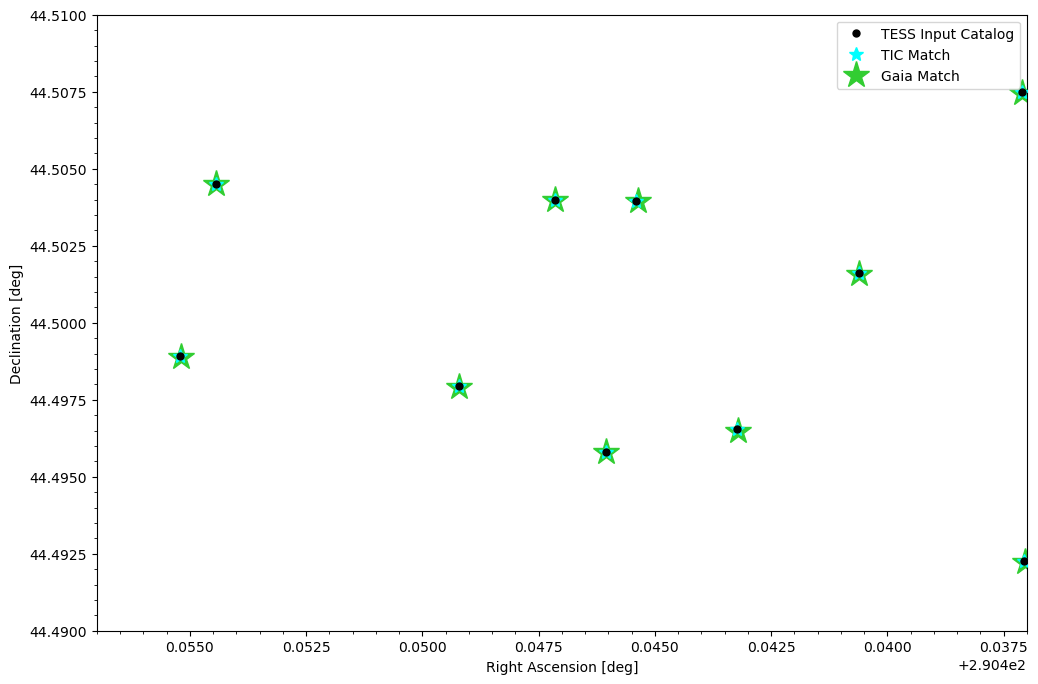

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.plot(tic_data['ra'],tic_data['dec'],'k.',ms=10,label='TESS Input Catalog',zorder=5)
plt.plot(matched_table['ra'],matched_table['dec'],c='cyan',marker='*',ms=10,linestyle='',label='TIC Match',zorder=4)
plt.plot(matched_table['RAdeg'],matched_table['DEdeg'],c='limegreen',marker='*',ms=20,linestyle='',label='Gaia Match',zorder=1)
plt.legend(loc='best')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.xlim([290.437,290.457])
plt.ylim([44.49,44.51])
plt.minorticks_on()
plt.gca().invert_xaxis()
plt.show()

Finally, plot the comparison of magnitudes. Since the TIC has a column for Gaia magnitude ('GAIAmag'), we can compare directly with the recorded magnitude in the Gaia table. But note that the TIC uses Gaia DR2, while our Gaia table is from DR3. So there are two potential mismatch cases if the magnitudes don't match:
1. The sources have different magnitude measurements between DR2 and DR3
2. The TIC coordinates matched to a different source in DR3

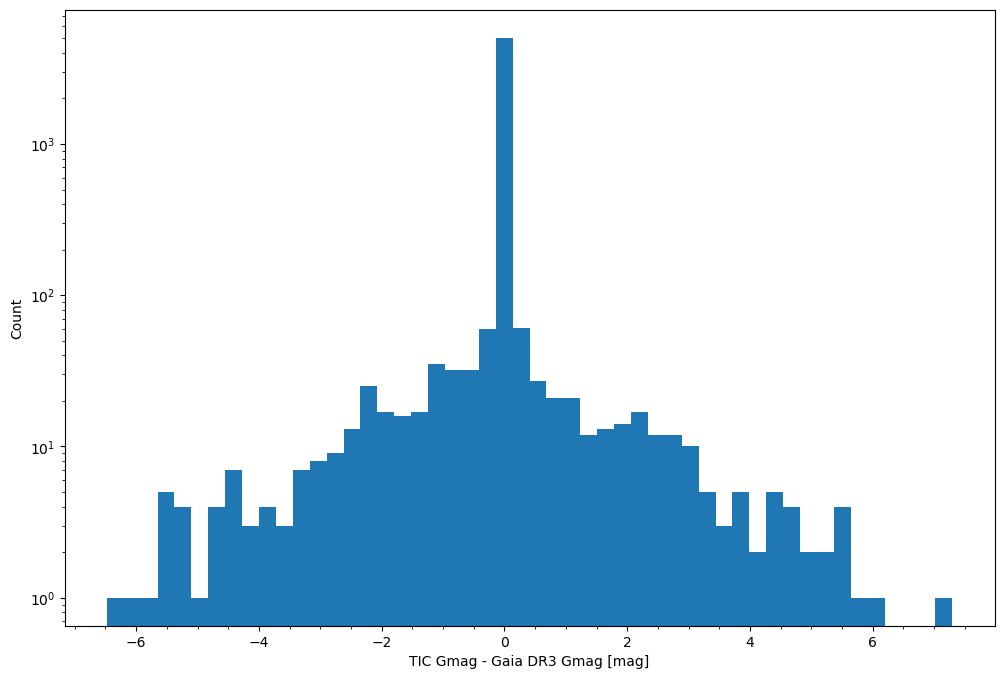

In [15]:
# Plot the comparison:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.hist(matched_table['GAIAmag'] - matched_table['Gmag'],bins=50)
plt.xlabel('TIC Gmag - Gaia DR3 Gmag [mag]')
plt.ylabel('Count')
plt.yscale('log')
plt.minorticks_on()
plt.show()

Importantly, not all Gaia DR2 sources have the same identifier in DR3. So even if a cross-match is successful, the IDs are not guaranteed to match. Let's compare:

In [17]:
source_id_diff = matched_table['Source'] - matched_table['GAIA']
print('Total sources matched:', len(matched_table))
print('Number of different DR2 vs. DR3 source ids:', len(np.nonzero(source_id_diff)[0]))

gmag_diff = matched_table['GAIAmag'] - matched_table['Gmag']
print('Number of Gmags differing by > 0.1 mag:', len(np.where(np.abs(gmag_diff) > 0.1)[0]))

Total sources matched: 5669
Number of different DR2 vs. DR3 source ids: 701
Number of Gmags differing by > 0.1 mag: 712


## Summary

Cross-matching is an important technique for combining data from different catalogs, and there are a few tools that are helpful for cross-matching. We've also highlighted some useful spot checks for cross-matches to make sure things are performing the way we want them to. Use these tips to kickstart your science!